In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sbr
import matplotlib.pyplot as mpl
import datetime as dt
import geopy.distance as distance

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetnew123/datanew.xlsx


In [2]:
pip install xlrd


     |████████████████████████████████| 96 kB 368 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install openpyxl

     |████████████████████████████████| 243 kB 404 kB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=ed457fea26dd753937458918385a41dce552cd9162cdece6614cf02c75effdcd
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopy 

Note: you may need to restart the kernel to use updated packages.


# READ CSV FILE & preprocessing it into subset df


In [5]:
df1=pd.read_excel(r"../input/datasetnew123/datanew.xlsx",sheet_name="sheet1")
df1=df1.dropna()

#print(df2)

In [6]:
df2=df1[["start time","end time","location(latitude/lontitude)"]]
df2["Durations"]=(df1["end time"]-df1["start time"]).dt.total_seconds()
df2=df2.groupby(by="location(latitude/lontitude)").sum()
df2=df2.reset_index()
df2["Combined_longitude_latitude"]=[tuple(y for y in x.split("/")) for x in df2["location(latitude/lontitude)"]]
df2=df2[["Durations","Combined_longitude_latitude"]]
df2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Durations,Combined_longitude_latitude
0,1507810.0,"(22.522803, 114.218796)"
1,643543.0,"(24.284812, 102.999068)"
2,50378.0,"(25.222206, 117.086322)"
3,3755547.0,"(26.139329, 103.078562)"
4,763464.0,"(26.215115, 109.744661)"
...,...,...
2764,15654.0,"(41.677262, 125.960124)"
2765,106027.0,"(41.835279, 123.498927)"
2766,92737.0,"(46.247857, 128.762232)"
2767,1808387.0,"(46.777465, 131.812182)"


## sample the data based on n

In [69]:
n=int(input("enter the value of base station present."))
df3=df2.sample(n)
df3=df3.reset_index(drop=True)
df3


enter the value of base station present. 200


,Durations,Combined_longitude_latitude
0,2075266.0,"(31.285741, 121.626244)"
1,19714.0,"(31.202262, 121.564812)"
2,3221.0,"(31.303333, 121.455058)"
3,23904.0,"(31.250978, 121.44639)"
4,37162.0,"(31.25867, 121.428896)"
...,...,...
195,23902.0,"(31.244568, 121.441817)"
196,10697.0,"(31.196975, 121.440602)"
197,14974.0,"(31.229191, 121.453189)"
198,31259.0,"(31.224385, 121.143509)"


In [70]:
def random_approach(server_count,df3):
    #df3=df3.sort_values("Durations",axis=1,ascending=False).reset_index(drop=True)
    df3=df3.reset_index(drop=True)
    #print(df3)
    #print(len(df3))
    closest_server_arr=[]
    for index_of_base_station in range(len(df3)):
        closest_server=0
        minimum_dist=np.inf
        for server in range(server_count):
            dist1=distance.distance(df3.iloc[index_of_base_station]["Combined_longitude_latitude"],df3.iloc[server]["Combined_longitude_latitude"]).km
            if(dist1<minimum_dist):
                minimum_dist=dist1
                closest_server=server
        closest_server_arr.append(closest_server)
    return (closest_server_arr)


def AccessDelay(closest_server_arr,df3):
    #print(len(closest_server_arr))
    # it must be equal to the length of dframe i.e each base station has chosen its nearest edgeserver.
    
    #but edge servers are placed near base station itself . so we are idirectly comparing DISTANCE between 2 B.STATION
    access_delay=0
    i=0
    for closest_server in closest_server_arr:
        access_delay+=distance.distance(df3.iloc[closest_server]["Combined_longitude_latitude"],df3.iloc[i]["Combined_longitude_latitude"]).km
        i+=1
    return access_delay
    


    """OR for each of the base syation from 1 to n, each has chosen its nearest edge server for which the distance is calculated and 
     added iteratively to finds the overall access delay for given set of edge server count"""

#      for i in range(len(df3)):
#             access_delay+=distance.distance(df3.iloc[closest_server[i]]["Combined_longitude_latitude"],df3.iloc[i]["Combined_longitude_latitude"]).km
#      return access_delay


def Workload_balance(closest_server_arr,df3):
    edge_servers=dict.fromkeys(closest_server_arr,0)
    """# edge_servers contains all the closest servers arranged in dictionary format where each of the edge server acts as key with value pair as "0" """
    """i.e an array of closest edge servers converted to dictionary"""
    for index,row in df3.iterrows():
        edge_servers[closest_server_arr[index]] +=  row["Durations"]
    total = 0
    mean = sum(edge_servers.values())/len(edge_servers)
    for key,value in edge_servers.items():
        total += (value - mean)**2
    return np.sqrt(total/len(edge_servers))
    

In [71]:
def main():
    server_counts=[]
    ADSol_Arr,WBSol_Arr=[],[]
    server_count_set=int(input("enter the value of server count set."))
    # indicates the length of the server_count_set
    random_array=list(np.random.randint(4,n,server_count_set))
    print(random_array,"server_count_set")
    for server_count in random_array:
        print(server_count,"server count")
        closest_server_arr=random_approach(server_count,df3)
        
        ##perfrom calculation of access delay
        ADSol_Arr.append(AccessDelay(closest_server_arr,df3))
        
        # perfrom worklaod balance for given set of servers
        WBSol_Arr.append(Workload_balance(closest_server_arr,df3))
        
        server_counts.append(server_count)
    #mpl.figure()
    """Plotting of Access delay """
    mpl.scatter(server_counts,ADSol_Arr)
    mpl.xlabel("set of edge servers considered")
    mpl.ylabel("Access delay ")
    mpl.show()
    #print(ADSol_Arr)
    """Averaging access delay and minimum access delay of all the lot"""
    Average_access_delay=(sum(ADSol_Arr)/len(ADSol_Arr))
    print(f"Average access delay for given  set of server_count in a server set is {Average_access_delay}")
    print()
    
    Access_delay_dictionary=dict(zip(ADSol_Arr,server_counts))
    minimum_access_delay=min(Access_delay_dictionary.keys())
    print(f"Minimum access delay for given set of servers {Access_delay_dictionary[minimum_access_delay]} is {minimum_access_delay}")
    print()
    
    #print(server_counts)
    
    """plotting for Workload balance"""
    mpl.scatter(server_counts,WBSol_Arr)
    mpl.xlabel("set of edge servers considered")
    mpl.ylabel(" WLB")
    mpl.show()                                                                            
   # print(WBSol_Arr)
    
    """Averaging Workload balance and minimum access delay of all the lot"""
    
    Average_Workload_balance=(sum(WBSol_Arr)/len(WBSol_Arr))
    print(f"Average workload balance for given  set of server_count in a server set is {Average_Workload_balance}")
     print() 
    Workload_Balance_dictionary=dict(zip(WBSol_Arr,server_counts))
    minimum_Workload_Balance=min(Workload_Balance_dictionary.keys())
    print(f"Minimum Workload balance for given set of servers {Workload_Balance_dictionary[minimum_Workload_Balance]} is {minimum_Workload_Balance}")
    print()
   


enter the value of server count set. 10


[56, 120, 74, 96, 39, 79, 20, 146, 116, 158] server_count_set
56 server count
120 server count
74 server count
96 server count
39 server count
79 server count
20 server count
146 server count
116 server count
158 server count
[56, 120, 74, 96, 39, 79, 20, 146, 116, 158]
[636.6315323453755, 246.23958588088544, 482.36088771903525, 321.94163038023663, 914.301286862788, 426.74273167023154, 1314.6506127116845, 136.08750644004266, 249.560108517225, 82.24514526087272]
Average access delay for given  set of server_count in a server set is 481.0761027788377
Minimum access delay for given set of servers 158 is 82.24514526087272


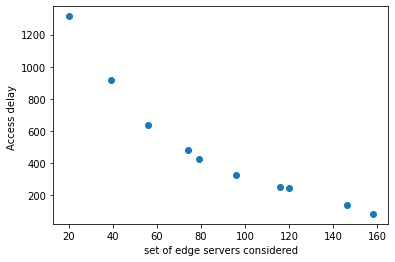

[1810554.424099508, 992931.7204759546, 1431337.2872921352, 1186701.5503749526, 2359367.8032067213, 1351722.3048171804, 4287265.379146093, 866938.359567016, 1001705.0856588703, 831064.4629402915]
Average workload balance for given  set of server_count in a server set is 1611958.8377578724
Minimum Workload balance for given set of servers 158 is 831064.4629402915


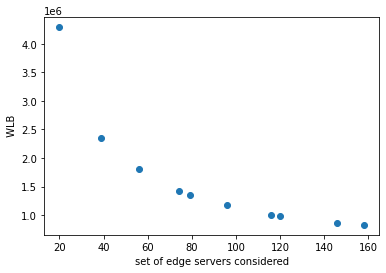

In [72]:
main()

In [58]:
list1=[1,2,3,4,5]
list2=[6,7,8,9,10]
my_dict=dict(zip(list1,list2))
print(my_dict)
minvalue=min(my_dict.keys())
print(minvalue)
print(my_dict[minvalue])

{1: 6, 2: 7, 3: 8, 4: 9, 5: 10}
1
6


In [24]:
arr1=[]
random_arr=list(np.random.randint(1,20,5))

for i in range(1,20,5):
    print(i)
print(random_arr)
for i in random_arr:
        arr1.append(i)
arr1

1
6
11
16
[11, 10, 13, 19, 3]


[11, 10, 13, 19, 3]